#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

random.seed(2)
%matplotlib inline


drive.mount('/content/drive')
IMAGE_PATH = '/content/drive/My Drive/UCB_MIDS_2023/w207/CNN_images/' 
LABEL_PATH = '/content/drive/My Drive/UCB_MIDS_2023/w207/CNN_labels/' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The labeling procedure follows 5 possible ratings: 0, 1, 2, 3, 4. Each image is characterized by a tuple (e,e), which corresponds to its scores by a human rater and a predicted rater.

Let's load the 2D images and their corresponding labels.

``labels``

In [3]:
labels = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', labels.shape)
print('Unique diagnosis codes:', np.sort(labels.diagnosis.unique()))
labels.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes:

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


``images``

In [4]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

---
### Step 3: Exploratory Data Analysis (EDA)

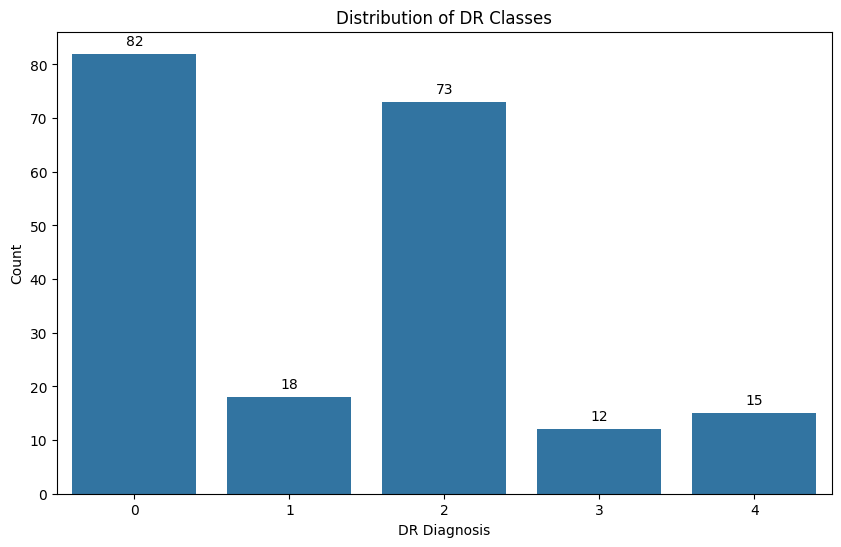

In [6]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='diagnosis', data=labels)
plt.title('Distribution of DR Classes')
plt.xlabel('DR Diagnosis')
plt.ylabel('Count')

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

#### Printing some images

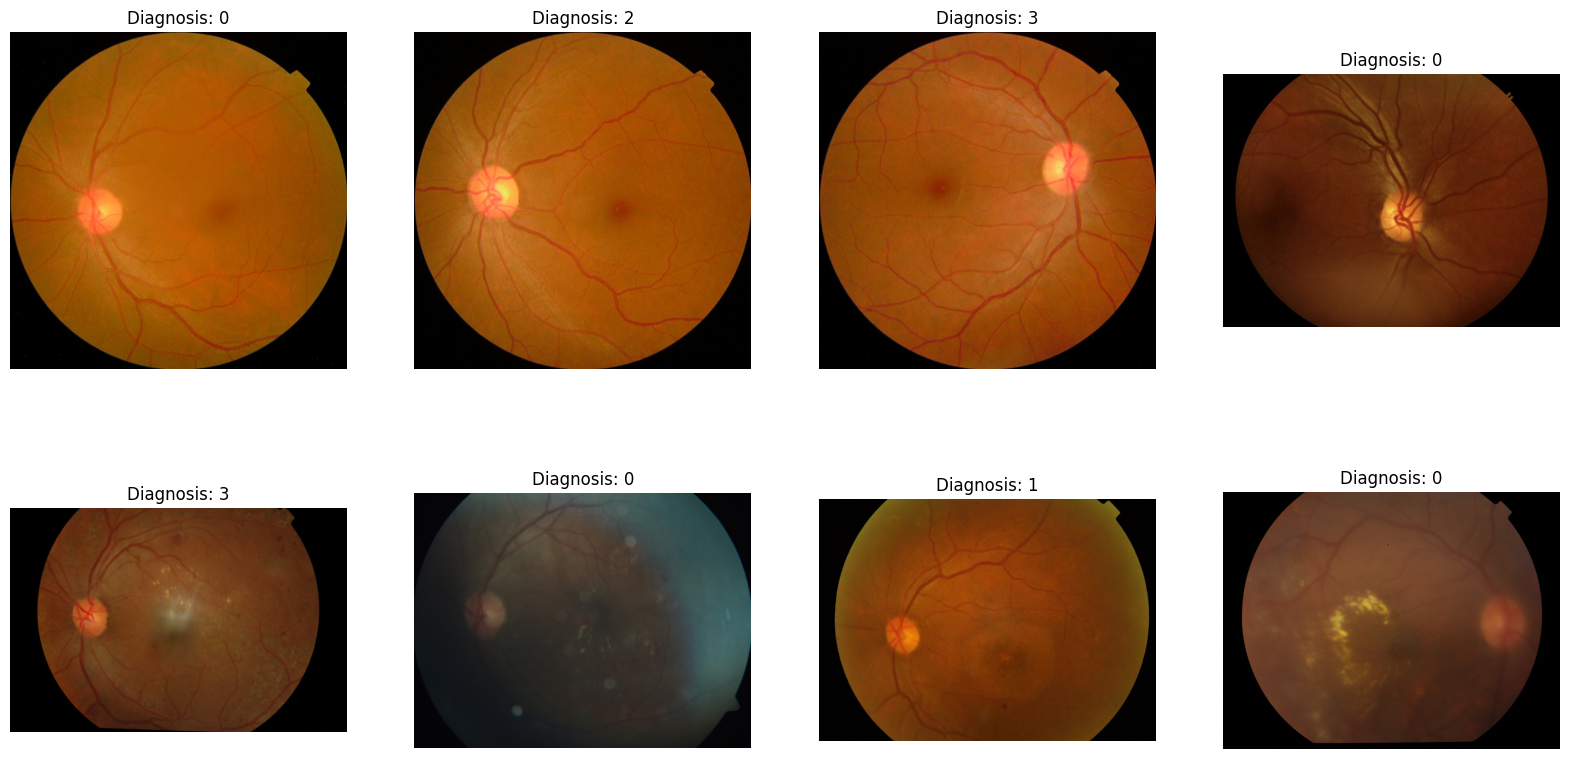

In [7]:
def plot_sample_images(images, labels, num_images=8):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        index = random.randint(0, len(images) - 1)
        img = images[index]
        label = labels.loc[index, 'diagnosis']
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f'Diagnosis: {label}')
        plt.axis('off')
    plt.show()

# Load images
images = []
for img_name in os.listdir(IMAGE_PATH):
    img_path = os.path.join(IMAGE_PATH, img_name)
    img = load_img(img_path)
    images.append(img)

# Plot sample images
plot_sample_images(images, labels)

Each image seems to be consistent in size. Some of them are clear and some have some motion blur and fadedness. It is difficult to tell which features contribute to a higher diagnosis score.

---
### Step 4: Data preprocessing

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


In [17]:
np.random.seed(1234)

no_refer = labels[labels.diagnosis.isin((0,1))]
refer = labels[labels.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

Next, we will use the ``preprocess_data_part1()`` function defined below to generate lists of images and labels (images_mini and y_mini) based on the values in the temp_no_refer and temp_refer lists. Note that the size of the image is set to (224, 224).

In [18]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists

    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    temp_no_refer (str): list of labels for the no refer category
    temp_refer (str): list of labels for the refer category

    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini`
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue


        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )

        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten()

    return images_mini, y_mini

In [19]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


1. shuffle images and labels before splitting the data

2. using a (0.6,0.2,0.2)train/validation/test set split

3. perform image transformation and augmentation, as follows:
    * Applied on training set only:
         - created additional copies (augmentations) of the training images by flipping left right each image
         - concatenated the augmented images to the original training images. 
    * Applied on training, validation, and test sets:
        - rescale images by dividing each pixel by 255.0

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [25]:
def preprocess_data_part2(images, labels, splits=(0.6, 0.2, 0.2)):
    """ Split data into train, validation and test sets; apply transformations and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    """

    # Set random seed for reproducibility
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # Shuffle data
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]

    # Create data splits
    total_samples = len(labels)
    train_size = int(splits[0] * total_samples)
    val_size = int(splits[1] * total_samples)

    X_train = images[:train_size]
    y_train = labels[:train_size]
    X_val = images[train_size:train_size + val_size]
    y_val = labels[train_size:train_size + val_size]
    X_test = images[train_size + val_size:]
    y_test = labels[train_size + val_size:]

    # Image augmentation (random flip) on training data
    X_train_augm = tf.image.flip_left_right(X_train)

    # Concatenate original X_train and augmented X_train_augm data
    X_train = np.concatenate([X_train, X_train_augm], axis=0)

    # Concatenate y_train (note the label is preserved)
    y_train = np.concatenate([y_train, y_train], axis=0)

    # Shuffle X_train and y_train
    shuffle_indices = tf.random.shuffle(tf.range(len(y_train), dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle_indices).numpy()
    y_train = tf.gather(y_train, shuffle_indices).numpy()

    # Rescale images by dividing each pixel by 255.0
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0

    return X_train, y_train, X_val, y_val, X_test, y_test

In [26]:
# define splits

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Step 5: Modeling

In [27]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
verbose=1,
patience=4,
mode='max',
restore_best_weights=True)

In [29]:
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model1 = tf.keras.Sequential()

# add convolutional layer to model1
model1.add(layers.Conv2D(
    filters=12,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu',
    input_shape=(224, 224, 3)
))
# add max pooling layer to model1
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
# add dropout layer to model1
model1.add(layers.Dropout(rate=0.3))
# add a flattening layer to model1
model1.add(layers.Flatten())
# add a classification layer to model1
model1.add(layers.Dense(1, activation='sigmoid'))
# build and compile model1
model1.build(input_shape=(None, 224, 224, 3))
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# print model1 summary
model1.summary()
# train model1 on (X_train, y_train) data
history = model1.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)
# evaluate the accuracy of model1 on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = model1.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model1.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 12)      588       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 12)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 12)      0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 1)                 150529    
                                                                 
Total params: 151117 (590.30 KB)
Trainable params: 151117 (590.30 KB)
Non-trainable params: 0 (0.00 Byte)
________________

Both the training (0.4792) and validation (0.5312) data are close in score and low, which may suggest underfitting. The model might be too simple to capture the underlying complexity of the data.   

Now that the baseline model is established, let's introduce some complexity. 

In [30]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize model2
model2 = tf.keras.Sequential()

# Add a series of convolutional and pooling layers to increase complexity
model2.add(layers.Conv2D(
    filters=32,  # Increased number of filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    input_shape=(224, 224, 3)
))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Conv2D(
    filters=64,  # Increased number of filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu'
))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Conv2D(
    filters=128,  # Increased number of filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu'
))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Conv2D(
    filters=256,  # Increased number of filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu'
))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
model2.add(layers.Dropout(rate=0.5))

# Flatten and add dense layers
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))  # Increased number of neurons
model2.add(layers.Dropout(rate=0.5))
model2.add(layers.Dense(1, activation='sigmoid'))

# Build and compile model2
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=['accuracy'])

# Print model2 summary to check parameters
model2.summary()

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model2 on (X_train, y_train) data
history = model2.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Evaluate the accuracy of model2 on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = model2.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model2.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 128)      

There is a vast improvement in both the training and validation scores, indicating that the increased model complexity was beneficial. This allowed the model to learn the underlying patterns of the images more robustly and gave it an improved generalization power.  

---
### Step 6: Evaluation

In [31]:
### YOUR CODE HERE ###
# Evaluate model1 on test data
test_loss_model1, test_acc_model1 = model1.evaluate(X_test, y_test, verbose=0)
print(f"Model1 Test Accuracy: {test_acc_model1:.4f}")

# Evaluate model2 on test data
test_loss_model2, test_acc_model2 = model2.evaluate(X_test, y_test, verbose=0)
print(f"Model2 Test Accuracy: {test_acc_model2:.4f}")

Model1 Test Accuracy: 0.5312
Model2 Test Accuracy: 0.9062


The increased complexity of model2 has the capacity to capture intricate features and complex patterns. However, there is a tradeoff in that model1 took under 1 minute to run, while model2 took 6 minutes.